In [76]:
import autorootcwd
import os
import pandas as pd
from src.exploratory_data_analysis import gather_data
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize

# Benchmark results

After performing the expansion of IPTC category descriptions, we compare their results with our baseline - IPTC category names embeddings.

In [69]:
def generate_predictions(df_articles, df_taxonomy, column_name_article_embedding, column_name_category_embedding):
    """Classifies articles based on the taxonomy.
    
    Args:
        df_articles (pd.DataFrame): Dataframe containing the articles.
        df_taxonomy (pd.DataFrame): Dataframe containing the taxonomy.
        
    Returns:
        pd.DataFrame: Dataframe containing the articles with the predicted categories.
    """
    
    article_embeddings = df_articles[column_name_article_embedding]
    category_embeddings = df_taxonomy[column_name_category_embedding]
    
    if isinstance(article_embeddings.iloc[0], str):
        article_embeddings = article_embeddings.apply(eval)
    
    if isinstance(category_embeddings.iloc[0], str):
        category_embeddings = category_embeddings.apply(eval)
    
    article_embeddings = np.array(article_embeddings.tolist())
    category_embeddings = np.array(category_embeddings.tolist())
    
    # compute similarity matrix of each article to each category
    similarity_scores = cosine_similarity(article_embeddings, category_embeddings)
    probabilities = similarity_scores / similarity_scores.sum(axis=1, keepdims=True)
    preds = np.argmax(probabilities, axis=1)
    preds_names = df_taxonomy['name'].iloc[preds].values
    
    # create output dataframe
    df_output = df_articles.copy()
    df_output['predicted_category_name'] = preds_names
    df_output['predicted_category_number'] = preds
    df_output['predicted_category_probability'] = np.max(probabilities, axis=1)
    df_output['predicted_categories_all_probabilities'] = [str(list(probs)) for probs in probabilities]
    
    return df_output

In [70]:
# read test dataset and taxonomy
# df_articles_testset = pd.read_csv('data/test_sets/test_set_random.csv')
df_articles_testset = pd.read_csv('labeling_app/labeled_data2.csv')
print(df_articles_testset.columns)

df_taxonomy = pd.read_csv('data/taxonomy/taxonomy_expanded.csv')
print(df_articles_testset.shape, df_taxonomy.shape)

Index(['byline', 'channels', 'desk', 'headline', 'keywords', 'categories',
       'lede', 'places', 'priority', 'id', 'versioncreated', 'text', 'photos',
       'next', 'related', 'previous', 'specialCoverage', 'bert_embedding',
       'label', 'high_label', 'mid_label', 'ada_embedding', 'date',
       'correction', 'editorialRemarks', 'videoAlbums', 'angle_embedding',
       'high_label2', 'mid_label2', 'label2', 'proposed_label'],
      dtype='object')
(300, 31) (17, 11)


In [71]:
df_output_testset_names = generate_predictions(df_articles_testset, df_taxonomy, 'ada_embedding', 'ada_embedding_name')
print(df_output_testset_names.shape)

df_output_testset_descriptions = generate_predictions(df_articles_testset, df_taxonomy, 'ada_embedding', 'ada_embedding_description')
print(df_output_testset_descriptions.shape)

df_output_testset_expanded_descriptions = generate_predictions(df_articles_testset, df_taxonomy, 'ada_embedding', 'final_description_ada_embedding')
print(df_output_testset_expanded_descriptions.shape)

(300, 35)
(300, 35)
(300, 35)


In [72]:
# # save test dataset predictions
# path = Path('results/')
# path.mkdir(parents=True, exist_ok=True)
# df_output_testset.to_csv(path / 'testset_predictions_expanded_taxonomy.csv', index=False)

In [77]:
def top_k_accuracy_score(y_true, y_score, k=5):
    """Computes top-k accuracy.
    
    Args:
        y_true (list): True labels.
        y_score (list of list): Predicted probabilities for each class.
        k (int): Number of top predictions to consider.
        
    Returns:
        float: Top-k accuracy score.
    """
    # Binarize the true labels to a one-vs-all fashion
    classes = np.unique(y_true)
    y_true_binarized = label_binarize(y_true, classes=classes)
    
    # Get the indices of the top k scores
    top_k_indices = np.argsort(y_score, axis=1)[:, -k:]
    
    # Check if the true label is among the top k predictions for each sample
    top_k_accuracy = 0
    for i in range(y_true_binarized.shape[0]):
        if y_true_binarized[i, top_k_indices[i]].sum() > 0:
            top_k_accuracy += 1
    
    top_k_accuracy /= y_true_binarized.shape[0]
    return top_k_accuracy

In [78]:
label_mapping = dict(zip(df_taxonomy['name'], list(range(len(df_taxonomy['name'])))))
true_labels_names = df_articles_testset["proposed_label"].tolist()
true_labels_ids = [label_mapping[label] for label in true_labels_names]
true_labels_one_hot = np.zeros((len(true_labels_names), len(df_taxonomy['name'])))

len(true_labels_names), len(true_labels_ids), true_labels_one_hot.shape

(300, 300, (300, 17))

In [115]:
predicted_label_names = df_output_testset_names['predicted_category_name']
accuracy = accuracy_score(true_labels_names, predicted_label_names)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_names, predicted_label_names, average='weighted')

predicted_label_probabilities = df_output_testset_names['predicted_categories_all_probabilities'].apply(eval).tolist()
top3_acc = top_k_accuracy_score(true_labels_names, predicted_label_probabilities, k=3)

metrics1 = [accuracy, precision, recall, f1, top3_acc]
print(top3_acc)

0.92


In [116]:
predicted_label_names = df_output_testset_descriptions['predicted_category_name']
accuracy = accuracy_score(true_labels_names, predicted_label_names)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_names, predicted_label_names, average='weighted')

predicted_label_probabilities = df_output_testset_descriptions['predicted_categories_all_probabilities'].apply(eval).tolist()
top3_acc = top_k_accuracy_score(true_labels_names, predicted_label_probabilities, k=3)

metrics2 = [accuracy, precision, recall, f1, top3_acc]
print(top3_acc)

0.6766666666666666


In [117]:
predicted_label_names = df_output_testset_expanded_descriptions['predicted_category_name']
accuracy = accuracy_score(true_labels_names, predicted_label_names)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_names, predicted_label_names, average='weighted')

predicted_label_probabilities = df_output_testset_expanded_descriptions['predicted_categories_all_probabilities'].apply(eval).tolist()
top3_acc = top_k_accuracy_score(true_labels_names, predicted_label_probabilities, k=3)

metrics3 = [accuracy, precision, recall, f1, top3_acc]
print(top3_acc)

0.8933333333333333


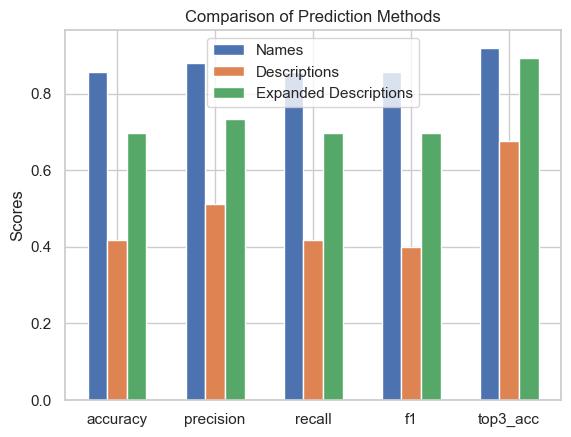

In [113]:
import matplotlib.pyplot as plt

# Define the metrics for each method
metrics_names = ['accuracy', 'precision', 'recall', 'f1', "top3_acc"]


# Create a bar chart
x = range(len(metrics_names))
width = 0.2

fig, ax = plt.subplots()
ax.bar(x, metrics1, width, label='Names', align='center')
ax.bar([p + width for p in x], metrics2, width, label='Descriptions', align='center')
ax.bar([p + width*2 for p in x], metrics3, width, label='Expanded Descriptions', align='center')

# Set the labels and title
ax.set_ylabel('Scores')
ax.set_title('Comparison of Prediction Methods')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(metrics_names)
ax.legend()

# Show the plot
plt.show()

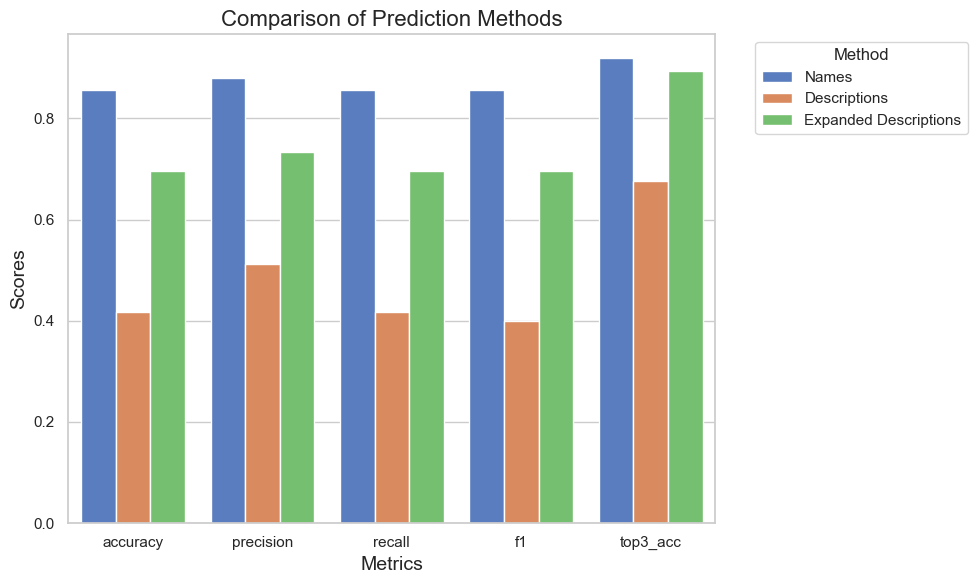

In [114]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert the metrics into a DataFrame for easier plotting with Seaborn
metrics_df = pd.DataFrame({
    'Names': metrics1,
    'Descriptions': metrics2,
    'Expanded Descriptions': metrics3
}, index=metrics_names).T.melt(var_name='Metric', value_name='Score', ignore_index=False).reset_index()

# Set the style of the seaborn plot
sns.set_theme(style="whitegrid")

# Create the barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Metric', y='Score', hue='index', data=metrics_df, palette='muted')

# Set the labels and title
barplot.set_ylabel('Scores', fontsize=14)
barplot.set_xlabel('Metrics', fontsize=14)
barplot.set_title('Comparison of Prediction Methods', fontsize=16)

# Place the legend outside the plot
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()